# Imports

In [24]:
import os
import shutil
import time
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL.Image
from IPython.display import Image
from sklearn.metrics import confusion_matrix , classification_report

import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

# Visualizing and preparing data

In [25]:
path_train = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [26]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

Total number of training data : 22424


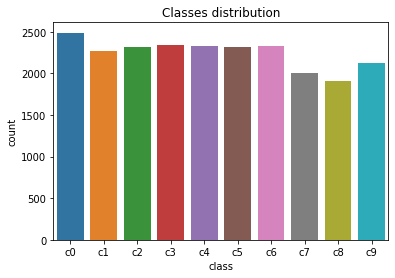

In [27]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(path_train,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

In [28]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomRotation(10),#Random rotations can help augment the training data and improve the model's ability to generalize to variations in the input images. 
                                 transforms.ToTensor()])#converts the image data NumPy array into a PyTorch tensor.

In [29]:
data = datasets.ImageFolder(root = path_train, transform = transform)

total_len = len(data)
print(total_len)
training_len = int(0.8*total_len)
print(training_len)
testing_len = total_len - training_len
print(testing_len)

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

22424
17939
4485


In [30]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=False)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=64,
                                          shuffle=False,
                                          drop_last=False)

torch.Size([3, 400, 400])
Label: c0 (safe driving)


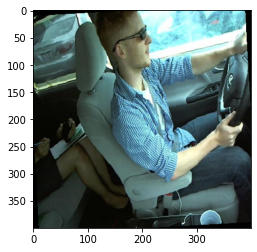

In [31]:
img,c = data[0]
print(img.shape)
print("Label:", classes[c], f"({class_dict[c]})")
plt.imshow(img.permute(1,2,0))
plt.show()

torch.Size([64, 3, 400, 400])
tensor([[2, 0, 1, 7, 0, 3, 5, 0],
        [3, 0, 0, 0, 2, 4, 3, 4],
        [4, 5, 7, 9, 1, 4, 3, 1],
        [8, 4, 0, 4, 8, 3, 2, 0],
        [0, 4, 9, 9, 2, 4, 2, 0],
        [8, 3, 9, 4, 5, 7, 0, 3],
        [8, 0, 5, 9, 0, 5, 6, 9],
        [6, 6, 1, 9, 2, 0, 8, 3]])


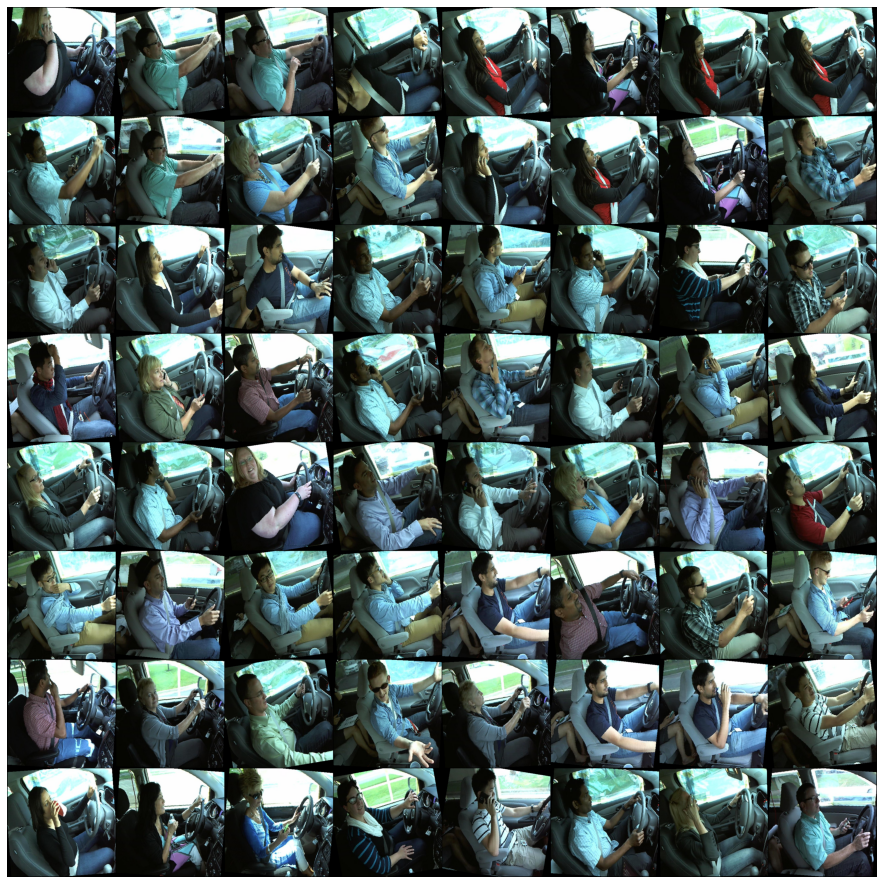

In [32]:
loader,labels = next(iter(train_loader))
print(loader.shape)
print(labels.view(8,8))
plt.figure(figsize=(16,16))
plt.imshow(torchvision.utils.make_grid(loader,nrow=8).permute((1,2,0)))
plt.axis('off')
plt.show()

# Creating and training the model

In [33]:
device = torch.device("cuda:0")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


The model works better with 'normalized' data.

In [34]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ])

In [35]:
data = datasets.ImageFolder(root = path_train, transform = transform)

total_len = len(data)
training_len = int(0.8*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [36]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

In [37]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [38]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [39]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 10) #No. of classes = 10
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [40]:
# takes around 5-6 minutes per epoch with GPU
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, duration: 351 s, loss: 0.2568, acc: 91.6444


 33%|███▎      | 1/3 [06:59<13:59, 419.78s/it]

Accuracy of the network on the test images: 98 %
Epoch 2, duration: 337 s, loss: 0.0329, acc: 99.0140


 67%|██████▋   | 2/3 [13:40<06:48, 408.67s/it]

Accuracy of the network on the test images: 99 %
Epoch 3, duration: 336 s, loss: 0.0170, acc: 99.4541


100%|██████████| 3/3 [20:20<00:00, 406.72s/it]

Accuracy of the network on the test images: 98 %
Finished Training


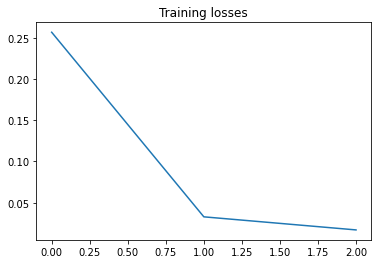

In [41]:
plt.title('Training losses')
plt.plot(training_losses)
plt.show()

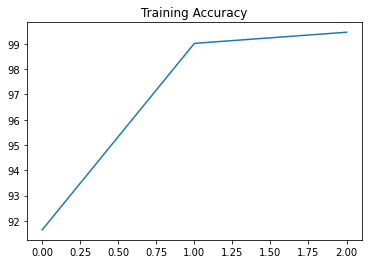

In [42]:
plt.title('Training Accuracy')
plt.plot(training_accs)
plt.show()

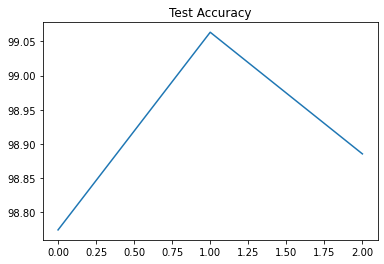

In [43]:
plt.title('Test Accuracy')
plt.plot(test_accs)
plt.show()

In [44]:
torch.save(model_ft.state_dict(), "/kaggle/working/model-driver")

# Testing the model and submitting csv

In [45]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load("/kaggle/working/model-driver"))
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
path_test = "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"
list_img_test = [img for img in os.listdir(path_test) if not img.startswith(".")]
list_img_test.sort()

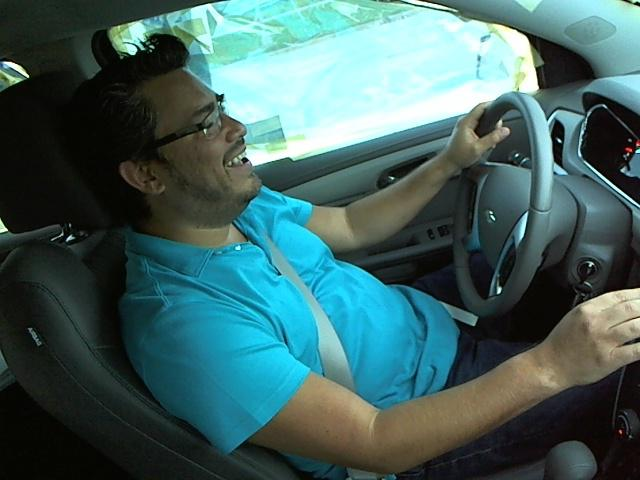

[0.0031, 0.0, 0.0, 0.0, 0.0001, 0.9967, 0.0001, 0.0, 0.0, 0.0]
Predicted class: operating the radio
Confidence: 0.9967
2nd answer: safe driving
Confidence: 0.0031


In [47]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

In [48]:
def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model(x),dim=1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [49]:
y_true,y_pred = true_pred(test_loader,model)

100%|██████████| 141/141 [01:04<00:00,  2.18it/s]


In [50]:
m = confusion_matrix(y_true, y_pred)
m  = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

<AxesSubplot:>

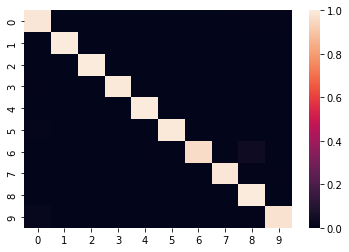

In [51]:
sns.heatmap(m)

We need to create a '/test/test' so that we can use `datasets.ImageFolder` and use a loader which is faster than iterating one by one (40 minutes) through all imgs/test files.

In [52]:
os.mkdir("/kaggle/working/test")

In [53]:
for img in tqdm(list_img_test):
    os.mkdir("/kaggle/working/test/"+img[:-4])
    source = path_test+"/"+img
    destination = "/kaggle/working/test/"+img[:-4]+"/"+img
    shutil.copy(source, destination)

100%|██████████| 79726/79726 [11:38<00:00, 114.13it/s]


In [54]:
transform_test = transforms.Compose([transforms.Resize((400, 400)),
                                     #transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [55]:
datatest = datasets.ImageFolder(root = "/kaggle/working/test",
                                transform = transform_test)

In [56]:
loader = torch.utils.data.DataLoader(dataset=datatest,
                                     batch_size=16,
                                     shuffle=False,
                                     drop_last=False,
                                     num_workers=2)

In [57]:
x,y = next(iter(loader))

torch.Size([16, 3, 400, 400])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


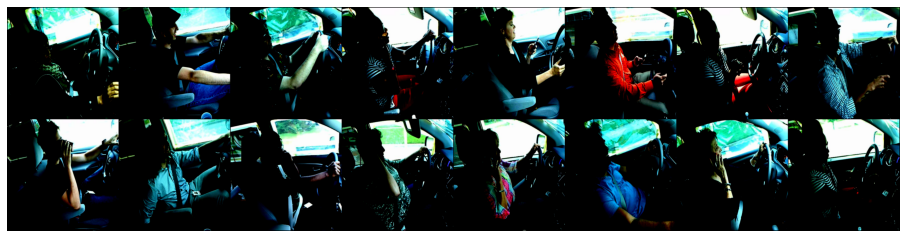

In [58]:
print(x.shape)
print(y)
plt.figure(figsize=(16,16))
plt.imshow(torchvision.utils.make_grid(x,nrow=8).permute((1,2,0)))
plt.axis('off')
plt.show()

In [59]:
df = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv",index_col = 0)

In [60]:
line = 0
for x,y in tqdm(loader,total = len(loader)) :
    output = model_ft(x.cuda())
    output = nn.Softmax(dim=1)(output)
    for i in range(len(output)) :
        proba = [float(elem) for elem in output[i]]
        df.iloc[line][:]=proba
        line += 1

100%|██████████| 4983/4983 [18:21<00:00,  4.53it/s]


In [61]:
for img in tqdm(list_img_test):
    os.remove("/kaggle/working/test/"+img[:-4]+"/"+img)
    os.rmdir("/kaggle/working/test/"+img[:-4])

100%|██████████| 79726/79726 [00:05<00:00, 15347.05it/s]


In [62]:
os.rmdir("/kaggle/working/test")

In [63]:
df.to_csv("/kaggle/working/submission.csv")

In [66]:
target_names = ["safe driving","texting - right","talking on the phone - right","texting - left","talking on the phone - left","operating the radio","drinking","reaching behind","hair and makeup","talking to passenger"]
m = classification_report(y_true, y_pred , target_names=target_names)
print(m)

                              precision    recall  f1-score   support

                safe driving       0.97      0.99      0.98       484
             texting - right       1.00      1.00      1.00       449
talking on the phone - right       1.00      1.00      1.00       478
              texting - left       1.00      0.99      0.99       455
 talking on the phone - left       0.99      1.00      1.00       466
         operating the radio       1.00      0.99      0.99       475
                    drinking       1.00      0.96      0.98       473
             reaching behind       1.00      0.99      0.99       390
             hair and makeup       0.94      1.00      0.97       379
        talking to passenger       0.99      0.97      0.98       436

                    accuracy                           0.99      4485
                   macro avg       0.99      0.99      0.99      4485
                weighted avg       0.99      0.99      0.99      4485



In [69]:
torch.save(model.state_dict(), "State_Farm_Distracted_Driver_Detection.h5")